## Flowers Classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 3s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [4]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

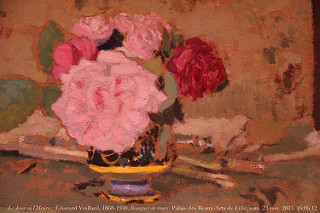

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

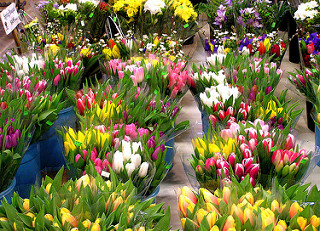

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                               validation_split = 0.2,
                                                               subset='training',
                                                               seed=20,
                                                               image_size=(img_width, img_height),
                                                               batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                               validation_split = 0.2,
                                                               subset='validation',
                                                               seed=20,
                                                               image_size=(img_width, img_height),
                                                               batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
val_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


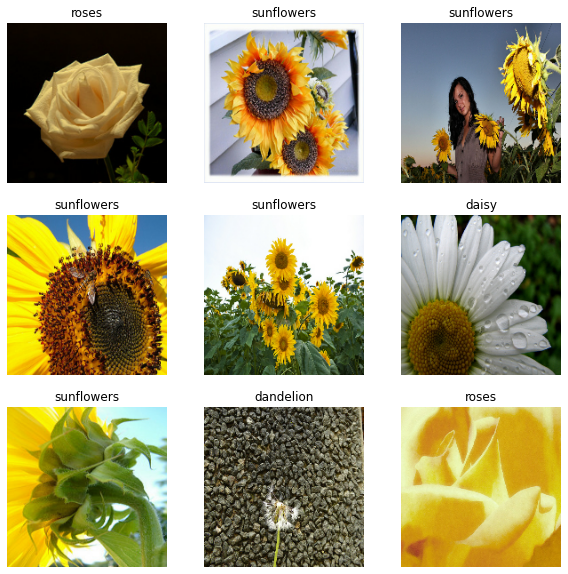

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
# Dataset.cache() - keeps the images in memory after they're loaded off disk during the first epoch
# Dataset.prefetch() - overlaps data preprocessing and model execution while training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
num_classes = 5

In [ ]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
 
early_stopping = EarlyStopping(patience=5, monitor='val_loss')
	
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.001, patience=5, mode='min', verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
callbacks = [
	    early_stopping,
	    reduce_lr,
	    model_checkpoint
	]

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [ ]:
history = model.fit(train_ds,
										validation_data=val_ds,
										epochs=20,
										callbacks=callbacks)

Epoch 1/20
92/92 [==============================] - 12s 60ms/step - loss: 1.3422 - accuracy: 0.4166 - val_loss: 1.1303 - val_accuracy: 0.5463
Epoch 2/20
92/92 [==============================] - 4s 41ms/step - loss: 0.9857 - accuracy: 0.6117 - val_loss: 1.0579 - val_accuracy: 0.5736
Epoch 3/20
92/92 [==============================] - 4s 41ms/step - loss: 0.7634 - accuracy: 0.7187 - val_loss: 0.9515 - val_accuracy: 0.6403
Epoch 4/20
92/92 [==============================] - 4s 41ms/step - loss: 0.5215 - accuracy: 0.8123 - val_loss: 1.0703 - val_accuracy: 0.6335
Epoch 5/20
92/92 [==============================] - 4s 41ms/step - loss: 0.3327 - accuracy: 0.8845 - val_loss: 1.1820 - val_accuracy: 0.6213
Epoch 6/20
92/92 [==============================] - 4s 41ms/step - loss: 0.2060 - accuracy: 0.9309 - val_loss: 1.5135 - val_accuracy: 0.6281
Epoch 7/20
92/92 [==============================] - 4s 41ms/step - loss: 0.1248 - accuracy: 0.9622 - val_loss: 1.5117 - val_accuracy: 0.6267
Epoch 8/20
9

<Figure size 432x288 with 0 Axes>

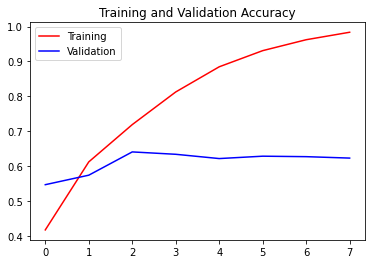

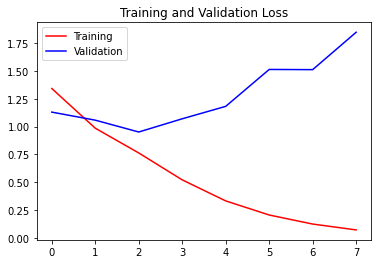

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Tackle Overfitting

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

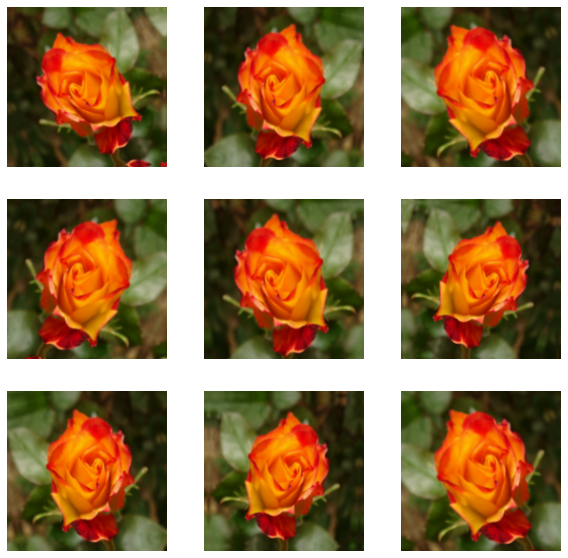

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
 
early_stopping = EarlyStopping(patience=5, monitor='val_loss')
	
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.001, patience=5, mode='min', verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [15]:
callbacks = [
	    early_stopping,
	    reduce_lr,
	    model_checkpoint
	]

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [18]:
history = model.fit(train_ds,
										validation_data=val_ds,
										epochs=20,
										callbacks=callbacks
										)

Epoch 1/20
92/92 [==============================] - 39s 67ms/step - loss: 1.3487 - accuracy: 0.4213 - val_loss: 1.1818 - val_accuracy: 0.5109
Epoch 2/20
92/92 [==============================] - 4s 47ms/step - loss: 1.0970 - accuracy: 0.5630 - val_loss: 1.1699 - val_accuracy: 0.5504
Epoch 3/20
92/92 [==============================] - 4s 47ms/step - loss: 1.0021 - accuracy: 0.6025 - val_loss: 1.0421 - val_accuracy: 0.5899
Epoch 4/20
92/92 [==============================] - 4s 48ms/step - loss: 0.8756 - accuracy: 0.6594 - val_loss: 1.0045 - val_accuracy: 0.6035
Epoch 5/20
92/92 [==============================] - 4s 48ms/step - loss: 0.8365 - accuracy: 0.6788 - val_loss: 0.9291 - val_accuracy: 0.6431
Epoch 6/20
92/92 [==============================] - 4s 47ms/step - loss: 0.7807 - accuracy: 0.6972 - val_loss: 0.9196 - val_accuracy: 0.6580
Epoch 7/20
92/92 [==============================] - 4s 47ms/step - loss: 0.7429 - accuracy: 0.7054 - val_loss: 0.9013 - val_accuracy: 0.6676
Epoch 8/20
9

<Figure size 432x288 with 0 Axes>

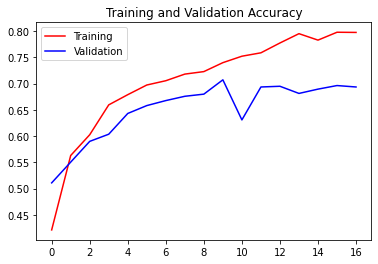

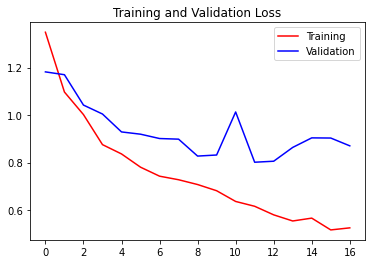

<Figure size 432x288 with 0 Axes>

In [19]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()